## imports

In [33]:
import math
import nltk
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from nltk.corpus import stopwords
from IPython.display import clear_output

nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\MoHaMmAd\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [2]:
english_stopwords = stopwords.words('english')
len(english_stopwords)

179

## read train data

In [3]:
df_train = pd.read_csv('./data/train_data.csv')
df_train

,id,qid1,qid2,question1,question2,is_duplicate
0,14,29,30,What are the laws to change your status from a...,What are the laws to change your status from a...,0
1,18,37,38,Why are so many Quora users posting questions ...,Why do people ask Quora questions which can be...,1
2,38,77,78,How do we prepare for UPSC?,How do I prepare for civil service?,1
3,58,117,118,I was suddenly logged off Gmail. I can't remem...,I can't remember my Gmail password or my recov...,1
4,60,121,122,How do I download content from a kickass torre...,Is Kickass Torrents trustworthy?,0
...,...,...,...,...,...,...
37245,404258,83107,222572,What is the difference between a psychologist ...,What is the difference between psychologist an...,1
37246,404276,24305,308365,What is copilotsearch.com?,What is ContenVania.com?,0
37247,404281,99131,81495,Why is Manaphy childish in Pokémon Ranger and ...,Why is Manaphy annoying in Pokemon ranger and ...,1
37248,404282,1931,16773,How does a long distance relationship work?,How are long distance relationships maintained?,1


In [4]:
uniqueQ2_train = df_train[['qid2', 'question2']].drop_duplicates()
N = len(uniqueQ2_train)
print('number of Q2_trains:', N)
uniqueQ2_train

number of Q2_trains: 16663


,qid2,question2
0,30,What are the laws to change your status from a...
1,38,Why do people ask Quora questions which can be...
2,78,How do I prepare for civil service?
3,118,I can't remember my Gmail password or my recov...
4,122,Is Kickass Torrents trustworthy?
...,...,...
37236,537844,"Is it safe to share PAN card scanned copy, Aad..."
37244,394117,What is the square root of 98?
37245,222572,What is the difference between psychologist an...
37246,308365,What is ContenVania.com?


## creat total_term_count

In [5]:
def countTotalTerms(documents):
    print("countTotalTerms, begin")

    ttc = dict()
    for i in documents:
        for j in i.replace('?', '').replace(',', '').split(" "):
            if j not in english_stopwords:
                if j in ttc.keys():
                    ttc[j] += 1
                else:
                    ttc[j] = 1

    print("countTotalTerms, end")
    return dict(sorted(ttc.items(), key=lambda item: item[1], reverse=True))

total_term_count = countTotalTerms(uniqueQ2_train['question2'])
print('number of terms:', len(total_term_count))

countTotalTerms, begin
countTotalTerms, end
number of terms: 13288


# unigram

## smoothed Unigram P(qi|D) function

In [6]:
def smoothedUniPqiD(document, Mu, terms): # smoothed P(w|D)
    # print("smoothedUniPqiD, begin")
    
    listTerms = list(terms)
    document = document.replace('?', '').replace(',', '')
    docTerms = document.split(" ")
    docLen = len(docTerms) # |D| or N
    colLen = sum(total_term_count.values()) # |C| and terms = CFw

    thisUniPqiD = dict.fromkeys(listTerms, 0)
    for term in listTerms:
        thisUniPqiD[term] = ((document.count(term) + (Mu * (terms[term] / colLen))) / (docLen + Mu))

    # print("smoothedUniPqiD, end")
    return list(thisUniPqiD.values())

#==============================================================================================

def computeAllUniPqiDs(documents, Mu, terms, load=False):
    print("computeAllUniPqiDs, begin")

    if load:
        uniPqiDs = np.load('./data/UniPqiDs.npy')
        print("Smoothed Unigram P(qi|D) loaded!")
    else:
        uniPqiDs = list()
        for document in list(documents.question2):
            uniPqiDs.append(
                smoothedUniPqiD(
                    document=document,
                    Mu=Mu,
                    terms=terms
                )
            )
        uniPqiDs = np.array(uniPqiDs)
        np.save('./data/UniPqiDs.npy', uniPqiDs)
        print("Smoothed Unigram P(qi|D) saved!")

    print("computeAllUniPqiDs, end")
    return uniPqiDs


## unigram functions

In [7]:
def uniPQD(query, docId, PqiDs, listTerms): # P(Q|D)
    # print("uniPQD, begin")

    queTerms = query.replace('?', '').replace(',', '').split(" ")

    PQD = 1
    for term in queTerms:
        if term in listTerms:
            PQD *= PqiDs[docId][listTerms.index(term)]

    # print("uniPQD, end")
    return PQD

#==============================================================================================

def computeSimilarUniPQD(PqiDs, query, documents, listTerms): # final language model weight
    print("computeSimilarUniPQD, begin")

    CPQD = dict()
    for id, document in enumerate(list(documents.question2)):
        CPQD[document] = uniPQD(
                query=query,
                docId=id,
                PqiDs=PqiDs,
                listTerms=listTerms
            )
    CPQD = dict(list(dict(sorted(CPQD.items(), key=lambda item: item[1], reverse=True)).items())[:10])

    print("computeSimilarUniPQD, end")
    return CPQD

#==============================================================================================

def computeUniResults(queries, PqiDs, documents, listTerms):
    print("computeUniResults, begin")

    results = dict()
    for i, (qid, query) in enumerate(zip(list(queries.qid1), list(queries.question1))):
        clear_output(wait=True)
        print("Progress computeUniResults:", i + 1, "/", len(queries))
        results[qid] = computeSimilarUniPQD(
                query=query,
                documents=documents,
                PqiDs=PqiDs,
                listTerms=listTerms
            )

    print("computeUniResults, end")
    return results


## read validation data

In [8]:
df_valid = pd.read_csv('./data/valid_data.csv')
df_valid

,id,qid1,qid2,question1,question2,is_duplicate
0,954,1903,1904,"Realistically speaking, what would happen to t...",Why is Donald Trump supported so much? What wi...,1
1,1672,3329,3330,Does global warming exist?,Is the global warming climate change things fo...,1
2,2261,4496,4497,How do I make India as corruption free?,What steps must Indians take to make India cor...,1
3,2460,4889,4890,What is the one thing that you would like to d...,"If you had an unlimited amount of money, what ...",1
4,2538,5043,5044,How do I stop my addiction to porn and masturb...,How do I stop addiction to porn?,1
...,...,...,...,...,...,...
1005,400711,190848,4412,Why do people always ask each and every silly ...,Why do people have to ask Quora for questions?,1
1006,401573,7091,46708,What workout clothes did guys wear in the year...,How would I dress like a workout guy from the ...,1
1007,402176,12017,27456,How can I recover my Gmail forgot my password ...,I forgot my Gmail password and I can't answer ...,1
1008,403363,74599,46840,Are there any other websites like Quora?,What are some similar websites to Quora?,1


In [9]:
uniqueQ1_valid = df_valid[['qid1', 'question1']].drop_duplicates()
len_uniqueQ1_valid = len(uniqueQ1_valid)
print('number of Q1_valid:', len_uniqueQ1_valid)
uniqueQ1_valid

number of Q1_valid: 173


,qid1,question1
0,1903,"Realistically speaking, what would happen to t..."
1,3329,Does global warming exist?
2,4496,How do I make India as corruption free?
3,4889,What is the one thing that you would like to d...
4,5043,How do I stop my addiction to porn and masturb...
...,...,...
681,91299,Career Advice: What are the success tricks for...
743,69958,Why is the media against Trump?
760,86944,Where can I watch one punch man with English d...
840,6734,What are some things new employees should know...


## metric functions

In [10]:
def p_at_k(predict, actual, k=10):
    # print("p_at_k, begin")

    p_at_ks = list()
    for i in predict.keys():
        thisActuals = list(actual[actual.qid1 == i].question2)
        thisP = 0
        thisPredicts = list(predict[i].keys())
        for l in range(k):
            if thisPredicts[l] in thisActuals:
                thisP += 1
        p_at_ks.append(thisP / k)

    # print("p_at_k, end")
    return sum(p_at_ks) / len(p_at_ks)

#==============================================================================================

def meanAveragePrecision(predict, actual, k=10):
    # print("meanAveragePrecision, begin")

    MAPs = list()
    for i in predict.keys():
        thisActuals = list(actual[actual.qid1 == i].question2)
        thisP = 0
        thisPList = list()
        thisPredicts = list(predict[i].keys())
        for l in range(k):
            if thisPredicts[l] in thisActuals:
                thisP += 1
                thisPList.append(thisP / (l + 1))
        MAPs.append(sum(thisPList) / len(thisActuals))

    # print("meanAveragePrecision, end")
    return sum(MAPs) / len(MAPs)

#==============================================================================================

def meanReciprocalRank(predict, actual):
    # print("meanReciprocalRank, begin")

    mrrs = list()
    for i in predict.keys():
        thisActuals = list(actual[actual.qid1 == i].question2)
        thisPredicts = list(predict[i].keys())
        for l in range(10):
            f = True
            if thisPredicts[l] in thisActuals:
                mrrs.append(1 / (l + 1))
                f = False
                break
        if f:
            mrrs.append(0)

    # print("meanReciprocalRank, end")
    return sum(mrrs) / len(mrrs)


## run function for unigram

In [11]:
def computeUniMetrics(Mu, uniqueQ1, uniqueQ2, df_val, terms, loadPqiDs=False):
    print("computeUniMetrics, begin")

    smoothedPqiDs = computeAllUniPqiDs(
            documents=uniqueQ2,
            Mu=Mu,
            terms=terms,
            load=loadPqiDs
        )
    results = computeUniResults(
            queries=uniqueQ1,
            PqiDs=smoothedPqiDs,
            listTerms=list(terms),
            documents=uniqueQ2_train
        )

    p_at_5_m = p_at_k(predict=results, actual=df_val, k=5)
    p_at_10_m = p_at_k(predict=results, actual=df_val)
    map5 = meanAveragePrecision(predict=results, k=5, actual=df_val)
    map10 = meanAveragePrecision(predict=results, actual=df_val)
    mrr = meanReciprocalRank(predict=results, actual=df_val)

    print("computeUniMetrics, end")
    return {
        'P@5': p_at_5_m,
        'P@10': p_at_10_m,
        'MAP5': map5,
        'MAP10': map10,
        'MRR': mrr
    }

## run unigram test on validation data

In [14]:
uniMetricsTestRes = computeUniMetrics(
        Mu=10,
        uniqueQ1=uniqueQ1_valid[:10],
        uniqueQ2=uniqueQ2_train,
        df_val=df_valid,
        terms=total_term_count
    )

print("P@5:", uniMetricsTestRes['P@5'])
print("P@10:", uniMetricsTestRes['P@10'])
print("MAP5:", uniMetricsTestRes['MAP5'])
print("MAP10:", uniMetricsTestRes['MAP10'])
print("MRR:", uniMetricsTestRes['MRR'])

Progress computeUniResults: 10 / 10
computeSimilarUniPQD, begin
computeSimilarUniPQD, end
computeUniResults, end
computeUniMetrics, end
P@5: 0.4600000000000001
P@10: 0.34
MAP5: 0.3523611111111111
MAP10: 0.45085317460317464
MRR: 0.8833333333333332


## Search for Mu ($\mu$)

In [15]:
validation_mu = dict()
Mus = [0.01, 0.1, 1, 10, 100, 1000]
for m in Mus:
    validation_mu[m] = computeUniMetrics(
        Mu=m,
        uniqueQ1=uniqueQ1_valid,
        uniqueQ2=uniqueQ2_train,
        df_val=df_valid,
        terms=total_term_count
    )

validation_mu = pd.DataFrame(validation_mu)
validation_mu

Progress computeUniResults: 173 / 173
computeSimilarUniPQD, begin
computeSimilarUniPQD, end
computeUniResults, end
computeUniMetrics, end


,0.01,0.10,1.00,10.00,100.00,1000.00
P@5,0.393064,0.398844,0.411561,0.413873,0.386127,0.334104
P@10,0.289595,0.294220,0.302312,0.304624,0.290751,0.256069
MAP5,0.304483,0.308789,0.318655,0.330685,0.308310,0.254369
MAP10,0.370294,0.378314,0.388543,0.403592,0.381680,0.318318
MRR,0.605962,0.612304,0.610152,0.614143,0.583643,0.501819


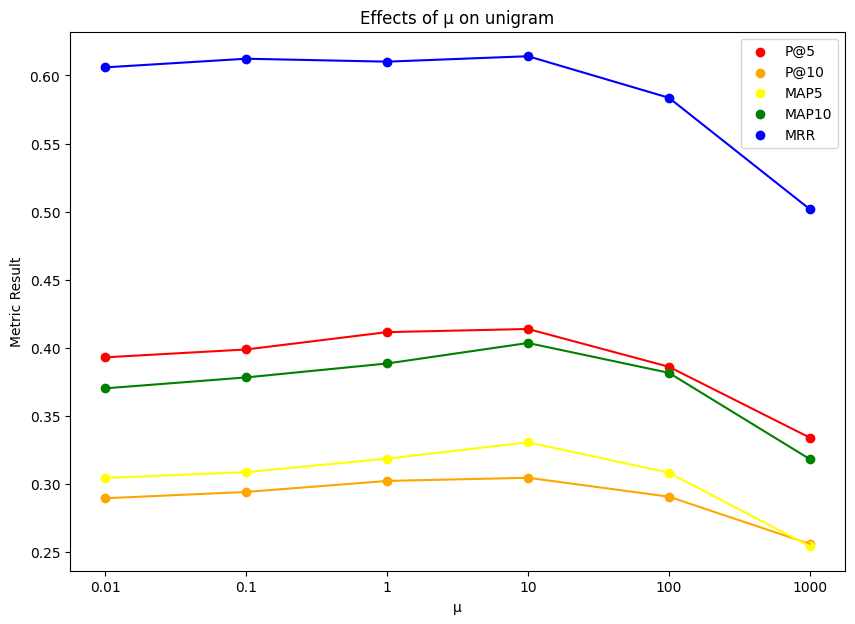

In [37]:
metrics = ["P@5", "P@10", "MAP5", "MAP10", "MRR"]
colors = ["red", "orange", "yellow", "green", "blue"]

for metric, color in zip(metrics, colors):
    xs = range(1, len(Mus) + 1)
    ys = [validation_mu[m][metric] for m in Mus]

    plt.plot(xs, ys, c=color)
    plt.scatter(xs, ys, c=color, label=metric)

plt.title("Effects of μ on unigram")
plt.xticks(xs, [str(m) for m in Mus])
plt.xlabel("μ")
plt.ylabel("Metric Result")
plt.legend()
plt.gcf().set_size_inches(10, 7)
plt.show()

## read test data

In [16]:
df_test = pd.read_csv('./data/test_data.csv')
df_test

,id,qid1,qid2,question1,question2,is_duplicate
0,249,499,500,How will the implementation of GST bill impact...,What exactly is GST bill and how exactly will ...,1
1,1287,2566,2567,What are some popular method to do suicide?,Is there some painless way to suicide?,1
2,2244,4464,4465,I am poor in English grammar so how should I i...,What can I do to improve my English Grammar?,1
3,2417,4804,4805,What are some good psychological hacks?,What is the coolest psychological trick?,1
4,2572,5110,5111,What is your best sexual experience?,What was your most favorite sexual experience?,1
...,...,...,...,...,...,...
975,403162,113631,2502,What places should I visit during my visit to ...,What are the places to visit for a honeymoon i...,1
976,403236,74247,6804,Is it possible to stop masturbating?,How should I stop masturbating?,1
977,403388,21982,51853,How do I learn quickly?,How can l learn faster?,1
978,403553,68327,68796,How can I trace phone calls from a cell phone?,How do I track a cell phone by number for free?,1


In [17]:
uniqueQ1_test = df_test[['qid1', 'question1']].drop_duplicates()
len_uniqueQ1_test = len(uniqueQ1_test)
print('number of Q1_test:', len(uniqueQ1_test))
uniqueQ1_test

number of Q1_test: 146


,qid1,question1
0,499,How will the implementation of GST bill impact...
1,2566,What are some popular method to do suicide?
2,4464,I am poor in English grammar so how should I i...
3,4804,What are some good psychological hacks?
4,5110,What is your best sexual experience?
...,...,...
588,174075,What is your favorite romantic comedy and why?
627,375503,How do I write an essay in English effectively?
728,134048,Which political party will win Punjab Assembly...
760,69042,What would happen if Donald Trump becomes pres...


## TEST Unigram

In [21]:
results_test_uni = computeUniMetrics(
        Mu=10,
        uniqueQ1=uniqueQ1_test,
        uniqueQ2=uniqueQ2_train,
        df_val=df_test,
        terms=total_term_count
    )

print("P@5:", results_test_uni['P@5'])
print("P@10:", results_test_uni['P@10'])
print("MAP5:", results_test_uni['MAP5'])
print("MAP10:", results_test_uni['MAP10'])
print("MRR:", results_test_uni['MRR'])

Progress computeUniResults: 146 / 146
computeSimilarUniPQD, begin
computeSimilarUniPQD, end
computeUniResults, end
computeUniMetrics, end
P@5: 0.5328767123287674
P@10: 0.3897260273972603
MAP5: 0.4379095008563879
MAP10: 0.5393953534867072
MRR: 0.8028620352250491


# bigram

## bigram functions

In [29]:
def biPQD(query, docId, uniPqiDs, Lambda, listTerms): # P(Q|D)
    # print("biPQD, begin")

    query = query.replace('?', '').replace(',', '')
    queTerms = query.split(" ")
    queLen = len(queTerms)

    # PQD = 1
    # if queTerms[0] in listTerms:
    #     PQD = uniPqiDs[docId][listTerms.index(queTerms[0])]

    # for i in range(1, queLen):
    #     if queTerms[i] in listTerms and queTerms[i - 1] in listTerms:
    #         PQD *= (
    #                 (Lambda * (query.count(queTerms[i - 1] + " " + queTerms[i]) / queTerms.count(queTerms[i - 1])))
    #                 +
    #                 ((1 - Lambda) * uniPqiDs[docId][listTerms.index(queTerms[i])])
    #             )

    PQD = 0
    if queTerms[0] in listTerms:
        PQD = uniPqiDs[docId][listTerms.index(queTerms[0])]

    for i in range(1, queLen):
        if queTerms[i] in listTerms and queTerms[i - 1] in listTerms:
            PQD += math.log(
                    (Lambda * (query.count(queTerms[i - 1] + " " + queTerms[i]) / queTerms.count(queTerms[i - 1])))
                    +
                    ((1 - Lambda) * uniPqiDs[docId][listTerms.index(queTerms[i])])
                )

    # print("biPQD, end")
    return PQD

#==============================================================================================

def computeSimilarBiPQD(uniPqiDs, query, documents, Lambda, listTerms): # final language model weight
    print("computeSimilarBiPQD, begin")

    CSPQD = dict()
    for id, document in enumerate(list(documents.question2)):
        CSPQD[document] = biPQD(
                query=query,
                docId=id,
                uniPqiDs=uniPqiDs,
                Lambda=Lambda,
                listTerms=listTerms
            )
    CSPQD = dict(list(dict(sorted(CSPQD.items(), key=lambda item: item[1], reverse=True)).items())[:10])

    print("computeSimilarBiPQD, end")
    return CSPQD

#==============================================================================================

def computeBiResults(queries, uniPqiDs, documents, Lambda, listTerms):
    print("computeBiResults, begin")

    results = dict()
    for i, (qid, query) in enumerate(zip(list(queries.qid1), list(queries.question1))):
        clear_output(wait=True)
        print("progress computeBiResults:", i + 1, "/", len(queries))
        results[qid] = computeSimilarBiPQD(
                query=query,
                uniPqiDs=uniPqiDs,
                documents=documents,
                Lambda=Lambda,
                listTerms=listTerms
            )

    print("computeBiResults, end")
    return results


## run function for bigram

In [30]:
def computeBiMetrics(Mu, uniqueQ1, uniqueQ2, df_val, Lambda, terms, loadPqiDs=False):
    print("computeBiMetrics, begin")

    smoothedUniPqiDs = computeAllUniPqiDs(
            documents=uniqueQ2,
            Mu=Mu,
            terms=terms,
            load=loadPqiDs
        )
    results = computeBiResults(
            queries=uniqueQ1,
            uniPqiDs=smoothedUniPqiDs,
            documents=uniqueQ2,
            listTerms=list(terms),
            Lambda=Lambda
        )

    p_at_5_m = p_at_k(predict=results, actual=df_val, k=5)
    p_at_10_m = p_at_k(predict=results, actual=df_val)
    map5 = meanAveragePrecision(predict=results, k=5, actual=df_val)
    map10 = meanAveragePrecision(predict=results, actual=df_val)
    mrr = meanReciprocalRank(predict=results, actual=df_val)
    
    print("computeBiMetrics, end")
    return {
        'P@5': p_at_5_m,
        'P@10': p_at_10_m,
        'MAP5': map5,
        'MAP10': map10,
        'MRR': mrr
    }

## run bigram test on validation data

In [39]:
biMetricsTestRes = computeBiMetrics(
        Mu=10,
        uniqueQ1=uniqueQ1_valid[:10],
        uniqueQ2=uniqueQ2_train,
        df_val=df_valid,
        Lambda=0.1,
        terms=total_term_count,
        loadPqiDs=True
    )

print("P@5:", biMetricsTestRes['P@5'])
print("P@10:", biMetricsTestRes['P@10'])
print("MAP5:", biMetricsTestRes['MAP5'])
print("MAP10:", biMetricsTestRes['MAP10'])
print("MRR:", biMetricsTestRes['MRR'])

progress computeBiResults: 10 / 10
computeSimilarBiPQD, begin
computeSimilarBiPQD, end
computeBiResults, end
computeBiMetrics, end
P@5: 0.22000000000000003
P@10: 0.15
MAP5: 0.13686507936507936
MAP10: 0.16623015873015873
MRR: 0.4333333333333333


## search for lambda ($\lambda$)

In [40]:
validation_lambda = dict()
lambdas = [0.01, 0.1, 0.25, 0.5, 0.75, 0.9, 0.99]

for l in lambdas:
    validation_lambda[l] = computeBiMetrics(
        Mu=10,
        uniqueQ1=uniqueQ1_valid,
        uniqueQ2=uniqueQ2_train,
        df_val=df_valid,
        Lambda=l,
        terms=total_term_count,
        loadPqiDs=True
    )

validation_lambda = pd.DataFrame(validation_lambda)
validation_lambda

progress computeBiResults: 173 / 173
computeSimilarBiPQD, begin
computeSimilarBiPQD, end
computeBiResults, end
computeBiMetrics, end


,0.01,0.10,0.25,0.50,0.75,0.90,0.99
P@5,0.236994,0.234682,0.230058,0.206936,0.080925,0.025434,0.010405
P@10,0.182081,0.179769,0.180925,0.157803,0.072254,0.024855,0.006936
MAP5,0.164873,0.162489,0.157881,0.141281,0.042654,0.012911,0.005127
MAP10,0.205158,0.200294,0.195891,0.170596,0.056947,0.016947,0.006252
MRR,0.387744,0.370981,0.363621,0.364272,0.151142,0.053544,0.015366


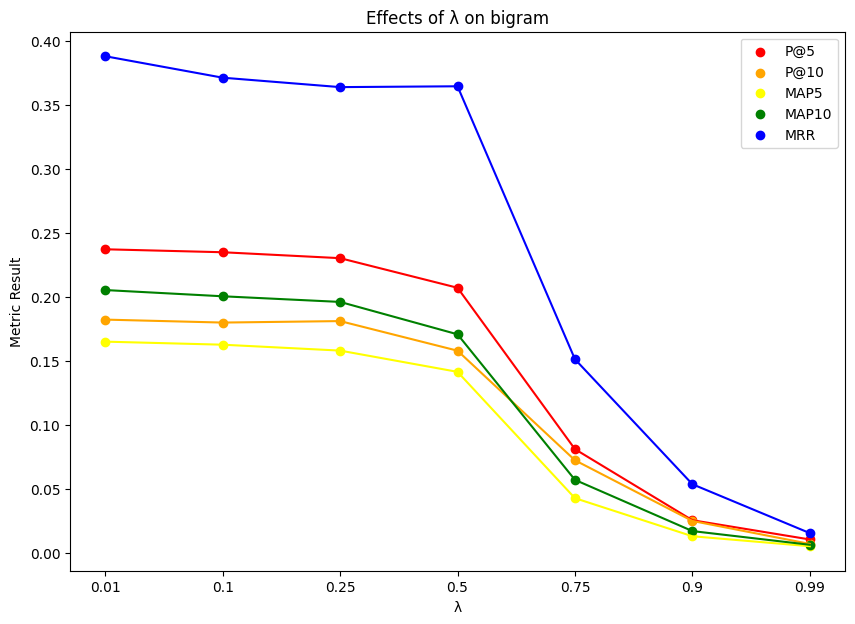

In [41]:
metrics = ["P@5", "P@10", "MAP5", "MAP10", "MRR"]
colors = ["red", "orange", "yellow", "green", "blue"]

for metric, color in zip(metrics, colors):
    xs = range(1, len(lambdas) + 1)
    ys = [validation_lambda[m][metric] for m in lambdas]

    plt.plot(xs, ys, c=color)
    plt.scatter(xs, ys, c=color, label=metric)

plt.title("Effects of λ on bigram")
plt.xticks(xs, [str(m) for m in lambdas])
plt.xlabel("λ")
plt.ylabel("Metric Result")
plt.legend()
plt.gcf().set_size_inches(10, 7)
plt.show()

## TEST Bigram

In [42]:
results_test_bi = computeBiMetrics(
        Mu=10,
        uniqueQ1=uniqueQ1_test,
        uniqueQ2=uniqueQ2_train,
        df_val=df_test,
        Lambda=0.01,
        terms=total_term_count,
        loadPqiDs=True
    )

print("P@5:", results_test_bi['P@5'])
print("P@10:", results_test_bi['P@10'])
print("MAP5:", results_test_bi['MAP5'])
print("MAP10:", results_test_bi['MAP10'])
print("MRR:", results_test_bi['MRR'])

progress computeBiResults: 146 / 146
computeSimilarBiPQD, begin
computeSimilarBiPQD, end
computeBiResults, end
computeBiMetrics, end
P@5: 0.28219178082191776
P@10: 0.20753424657534256
MAP5: 0.20883595807677682
MAP10: 0.25212134294316196
MRR: 0.449548814959774
